# Partie 2 - Régression - Rendement du maïs

### TOCHECK
- yeojon et BoxCox => normalisation
- varImp for feature importance
- [Recursive feature elimination](https://topepo.github.io/caret/recursive-feature-elimination.html)
- normalité
- homoscédasticité

## Packages and Helpers

In [2]:
PACKAGES = c('caret', 'e1071', 'elasticnet', 'gam', 'glmnet', 'kernlab', 'MASS', 'pls', 'randomForest', 'rpart')
for (package in PACKAGES) {
    if (!require(package, character.only=TRUE)) {
        install.packages(package)
        if (!require(package, character.only=TRUE))
            stop(paste("Package", package, "not found"))
    }
}
options(repr.plot.width=9, repr.plot.height=5)

In [3]:
tryCatch({
    library(doParallel)
    if (exists('cluster')) {
        print("Closing cluster")
        stopCluster(cluster)
    }
    
    cluster = makePSOCKcluster(5)
    registerDoParallel(cluster)
    print("Cluster created")
})

Loading required package: iterators
Loading required package: parallel
Warning message in sample.int(.Machine$integer.max - 1L, 1L):
“'.Random.seed[1]' is not a valid integer, so ignored”

[1] "Closing cluster"


ERROR: Error in checkCluster(cl): not a valid cluster


In [405]:
extract_x = function(data) data[, -grep('yield_anomaly', colnames(data))]
pca_to_data = function(pca, coeff=NULL) {
    pca_data = pca$x
    if (!is.null(coeff)) {
        sum_lambdas = cumsum(sort(pca$sdev, decreasing=TRUE)) / sum(pca$sdev)
        pca_data = pca_data[,1:which.min(abs(sum_lambdas - coeff))]
    }
        
    data = cbind(pca_data, mais.raw$yield_anomaly)
    colnames(data)[ncol(data)] = 'yield_anomaly'
    return(as.data.frame(data))
}

split = function(data, p=0.2) {
    set.seed(1234)
    test.index = createDataPartition(data$yield_anomaly, p=p, list=FALSE)
    return(list(
        train = mais[-test.index,],
        test = mais[test.index,]
    ))
}

### Plot functions

In [22]:
# Color gradient generator
color.gradient <- function(x, colors=c("#00AFBB", "#E7B800", "#FC4E07"), colsteps=100) {
  return( colorRampPalette(colors) (colsteps) [ findInterval(x, seq(min(x), max(x), length.out=colsteps)) ] )
}

In [23]:
# Pairs plot
CORR_GRAD = colorRampPalette(c('black', 'yellow', 'red'))(100)
pairs.corr = function(x, y) {
    usr = par("usr"); on.exit(par(usr))
    par(usr = c(0, 1, 0, 1))
    r = round(cor(x, y), digits=2)
    txt = paste0("R = ", r)
    text(0.5, 0.5, txt, cex = (1 + abs(r)), col=CORR_GRAD[round(abs(r)*100)])
}
    
pairs.scatter = function(x, y) {
    points(x, y, col=rgb(0,0,0,0.2))
}

In [24]:
# Intervals plot
plot_interval = function(x, lower, upper) {
    sorted = sort(x, index.return=TRUE)
    polygon(c(sorted$x, rev(sorted$x)),
            c(lower[sorted$ix], upper[rev(sorted$ix)]),
            col = rgb(0, 0.1, 1, 0.05),
            border= rgb(0, 0.1, 1, 0.5))
#     arrows(x, upper, x, lower, angle=90, tcode=3, length=0.1)
}

plot_pred_interval = function(interval, y_true, y_pred, main="Interval") {
    x = interval[,1]
    lower = interval[,2]
    upper = interval[,3]

    idx.obs.out = which((y_true < lower) | (y_true > upper))
    idx.pred.out = which((y_pred < lower) | (y_pred > upper))

    # Plot observations
    plot(x[-idx.obs.out],  y_true[-idx.obs.out], pch=1, col='blue',
         ylim=range(interval, y_true, y_pred),
         main=main, xlab='x', ylab='y interval')
    points(x[idx.obs.out], y_true[idx.obs.out],  pch=1, col='red')

    # Plot predictions
    points(x[-idx.pred.out], y_true[-idx.pred.out], pch=3, col='blue')
    points(x[idx.pred.out],   y_true[idx.pred.out], pch=3, col='red')
    
    # Plot interval and 0.1-line
    plot_interval(x, lower, upper)
    abline(0, 1)
}

plot_pred_intervals = function(model, data, ycols) {
    # Get observations and predictions
    y_true = data[,ycols]
    y_pred = predict(model, newdata=data)
    
    # Get intervals
    int_pred = predict(model, interval='prediction', newdata=data)
    int_conf = predict(model, interval='confidence', newdata=data)

    par(mfrow=c(1,2))
    plot_pred_interval(int_pred, y_true, y_pred, main="Prediction interval")
    plot_pred_interval(int_conf, y_true, y_pred, main="Confidence interval")
}

In [25]:
## QQ Normality plot
qq_plot = function(residuals) {
    qqnorm(residuals)
    qqline(residuals)
    print(shapiro.test(residuals))
}

In [26]:
# Predictions / expectations plot
pred_true_plot = function(y_true, y_pred) {
    plot(y_true, y_pred, xlab="y_true", ylab="y_pred", main="Predictions vs Expectations")
    abline(0, 1, col="red")
}

In [297]:
# PCA Plot variance explained by components
plot_pca_var = function(lambdas, coeffs = c(85, 90, 95), add_ticks=TRUE) {
    sum_lambdas = cumsum(sort(lambdas, decreasing=TRUE))
    sum_lambdas = sum_lambdas / sum_lambdas[length(sum_lambdas)] * 100
    pc_indexes = sapply(coeffs, FUN=function(coeff) which.min(abs(sum_lambdas - coeff)))

    plot(sum_lambdas, type='l',
         main='Principal Components Analysis',
         xlab='Principal components',
         ylab='Cumulative variance (%)')
    if (add_ticks) {
        axis(side = 1, at = pc_indexes)
        axis(side = 2, at = coeffs)
    }
    
    n = length(coeffs)
    cmap = heat.colors(n+1)
    for (i in 1:n) {
        pc_index = pc_indexes[i]
        lines(c(-10, pc_index), rep(coeffs[i], 2), col=cmap[n-i+1])
        lines(rep(pc_index, 2), c(0, coeffs[i]), col=cmap[n-i+1])
    }
}

In [205]:
# Studentized residuals plot
studentized_residuals_plot = function(residuals, threshold=2) {
    outliers = abs(residuals) > threshold
    plot(residuals,
         main=paste("Residuals (", sum(outliers), " outliers / ", length(outliers), ")", sep=""),
         col=ifelse(outliers, 'red', 'black'))
    abline(h = -threshold, col='red')
    abline(h = threshold, col='red')
}

In [29]:
# MSE Plot
mse_plot = function(y_true, y_pred) {
    squared_error = (y_true - y_pred)^2
    mse = mean(squared_error)
    plot(squared_error, ylab='squared error', main=paste('MSE', round(mse, digits=3)))
    abline(h=mse, col='red')    
}

## Exploration des données

> Semis en Avril et récolte en octobre/novembre

2300 individus et 58 variables

Variables:
- `yield_anomaly` (float): variable à prédire représentant l’anomalie de rendement de maïs (une valeur positive indique un rendement plus élevé
qu’attendu, une valeur négative indique une valeur perte de rendement par rapport à la valeur attendue), exprimée en tonne par ha.
- `year_harvest` (int): année (anonyme) de récolte (1 à 57)
- `NUMD` (int): numéro (anonyme) indiquant le département (de 1 à 94).
- `ETP_1`, ... ,`ETP_9` (float): Evapotranspiration potentielle moyenne mensuelle par année et par département (1= janvier, 9=septembre)
- `PR_1`, ... ,` PR_9` (float): Précipitation cumulée mensuelle par année et par
département (1= janvier, 9=septembre)
- `RV_1`, ... ,` RV_9` (float): Rayonnement moyen mensuel par année et par département (1= janvier, 9=septembre)
- `SeqPR1`, ... ,`SeqPR9` (float): Nombre de jours de pluie mensuel par année et
par département (1= janvier, 9=septembre)
- `Tn_1`, ... ,`Tn_9` (float): Température minimale journalière moyenne mensuelle par année et par département (1= janvier, 9=septembre)
- `Tx_1`, ... ,`Tx_9` (float): Température maximale journalière moyenne mensuelle par année et par département (1= janvier, 9=septembre)
- `IRR` (int): variable comprise entre 1 et 5 liée à la fraction de surface agricole irriguée dans chaque département. La valeur 1 indique une fraction faible, la valeur 5 indique une fraction élevée de surface irriguée.
Ces valeurs sont indicatives car établies sur la base d'information collectée pendant une seule année.

&nbsp;


Pour le prétraitement, nous allons:
1. chercher si des valeurs manquent
2. enlever les variables ayant une variabilitée faible
3. enlever les variables fortement corrélées

In [3]:
range_col = function(key, r=1:9) paste(key, r, sep='_')
range_cols = function(keys, r=1:9) {
    cols = c()
    for (key in keys)
        cols = c(cols, range_col(key, r))
    return(cols)
}

### Chargement des données maïs

In [3]:
# Load data
mais.raw = read.csv('./data/mais_train.csv')
mais.raw$X = NULL

mais.pre = mais.raw
# mais.pre$NUMD = as.factor(mais.pre$NUMD)
mais.pre$IRR = as.factor(mais.pre$IRR)

n = nrow(mais.pre)
p = ncol(mais.pre)

cat(n, 'x', p)
head(mais.pre)

2300 x 58

year_harvest,yield_anomaly,NUMD,IRR,ETP_1,ETP_2,ETP_3,ETP_4,ETP_5,ETP_6,⋯,Tn_9,Tx_1,Tx_2,Tx_3,Tx_4,Tx_5,Tx_6,Tx_7,Tx_8,Tx_9
50,0.1825038,16,3,0.682472,1.293110,1.699620,2.44748,3.14399,4.20854,⋯,9.26988,10.123400,13.16220,10.75830,13.9877,19.9540,22.4562,24.2189,23.6961,20.1262
33,-0.3845784,83,3,0.432387,0.623810,1.431020,2.39696,3.13113,2.94998,⋯,10.96170,5.252540,2.59379,12.21890,12.6402,13.7359,16.0640,21.3142,23.6133,21.0558
57,-3.1240055,64,1,0.284586,0.478381,1.204350,2.30868,2.48770,3.61130,⋯,9.33011,4.216180,4.53739,10.12610,14.7061,17.2825,22.0111,26.6244,25.4657,17.2345
23,0.3425881,50,3,0.304020,0.426170,0.780732,1.71382,1.85480,3.44557,⋯,10.39020,0.150477,1.89350,9.13836,12.9452,14.1650,18.9474,19.8015,21.7915,18.0109
35,1.3362104,30,5,0.298557,0.459541,1.450150,1.88462,2.54718,3.47661,⋯,9.49472,8.157450,4.14919,10.93550,14.4118,17.2658,20.9065,20.9661,22.6803,17.8078
37,1.2148426,36,3,0.978619,0.916539,1.822910,2.07887,2.93823,3.76420,⋯,12.53060,8.603350,12.48080,11.72800,14.4203,17.7080,20.8284,26.4588,24.4734,20.0928


Les données `ETP`, `PR`, `RV`, `SeqPR`, `Tn` et `Tx` correspondent à des mesures dans le temps, sur les 9 premiers mois de l'année de la récolte. Elles sont donc très sûrement corrélées entre elles.

In [9]:
# Summary of data
cat("Missing values:", sum(is.na(mais.pre)))
cat("\nData summary:")
summary(mais)

Missing values: 0
Data summary:

Aucune donnée ne manque. Les données n'ont pas l'air d'avoir de valeurs aberrantes.

In [10]:
count.unique = function(x) {
    n = length(unique(x))
    return(c(n, n / length(x)))
}
unique_freq = t(apply(mais, MARGIN=2, FUN=count.unique))
colnames(unique_freq) = c('n_unique', 'freq')
unique_freq

,n_unique,freq
year_harvest,38,0.016521739
yield_anomaly,2299,0.999565217
NUMD,94,0.040869565
IRR,5,0.002173913
ETP_1,2296,0.998260870
ETP_2,2295,0.997826087
ETP_3,2284,0.993043478
ETP_4,2285,0.993478261
ETP_5,2287,0.994347826
ETP_6,2289,0.995217391


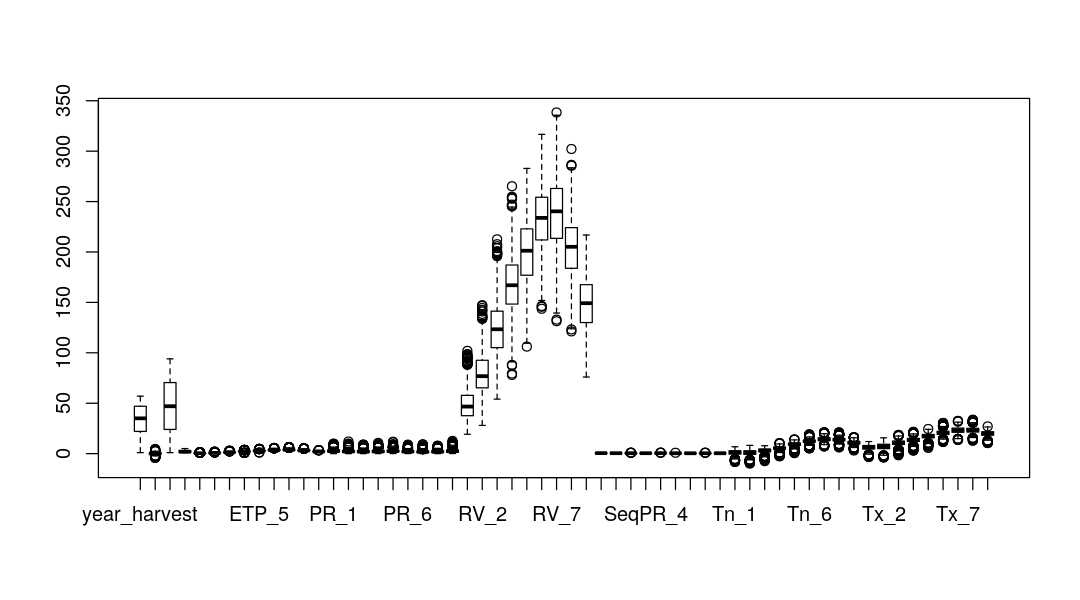

In [11]:
# boxplot(subset(mais, select = -c(year_harvest, NUMD, IRR, 23:31)))
boxplot(mais.pre)

### PCA

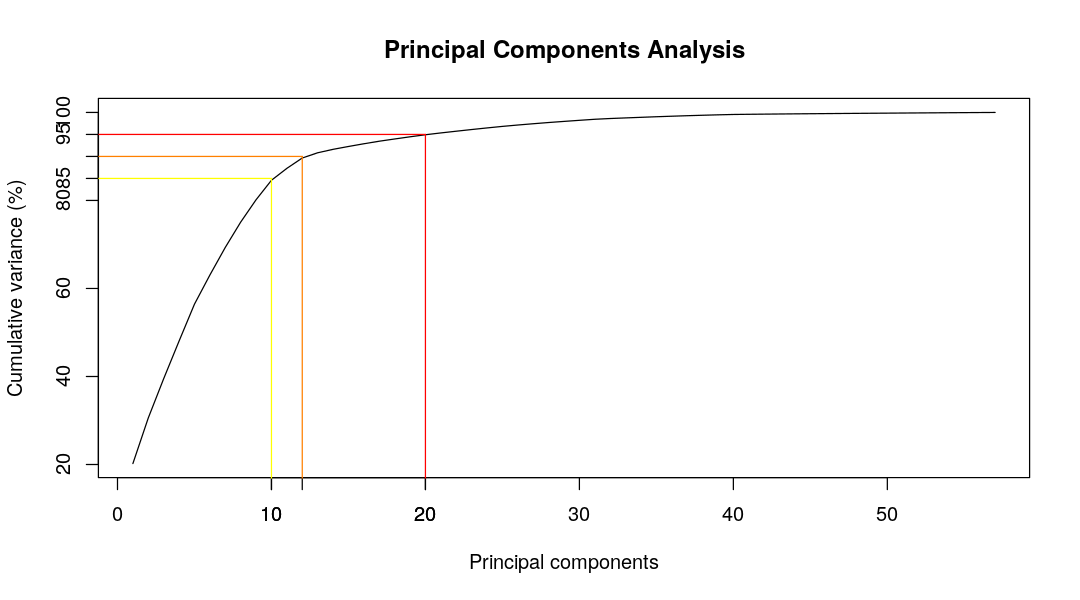

In [323]:
mais.pca = prcomp(extract_x(mais.raw))
plot_pca_var(mais.pca$sdev)

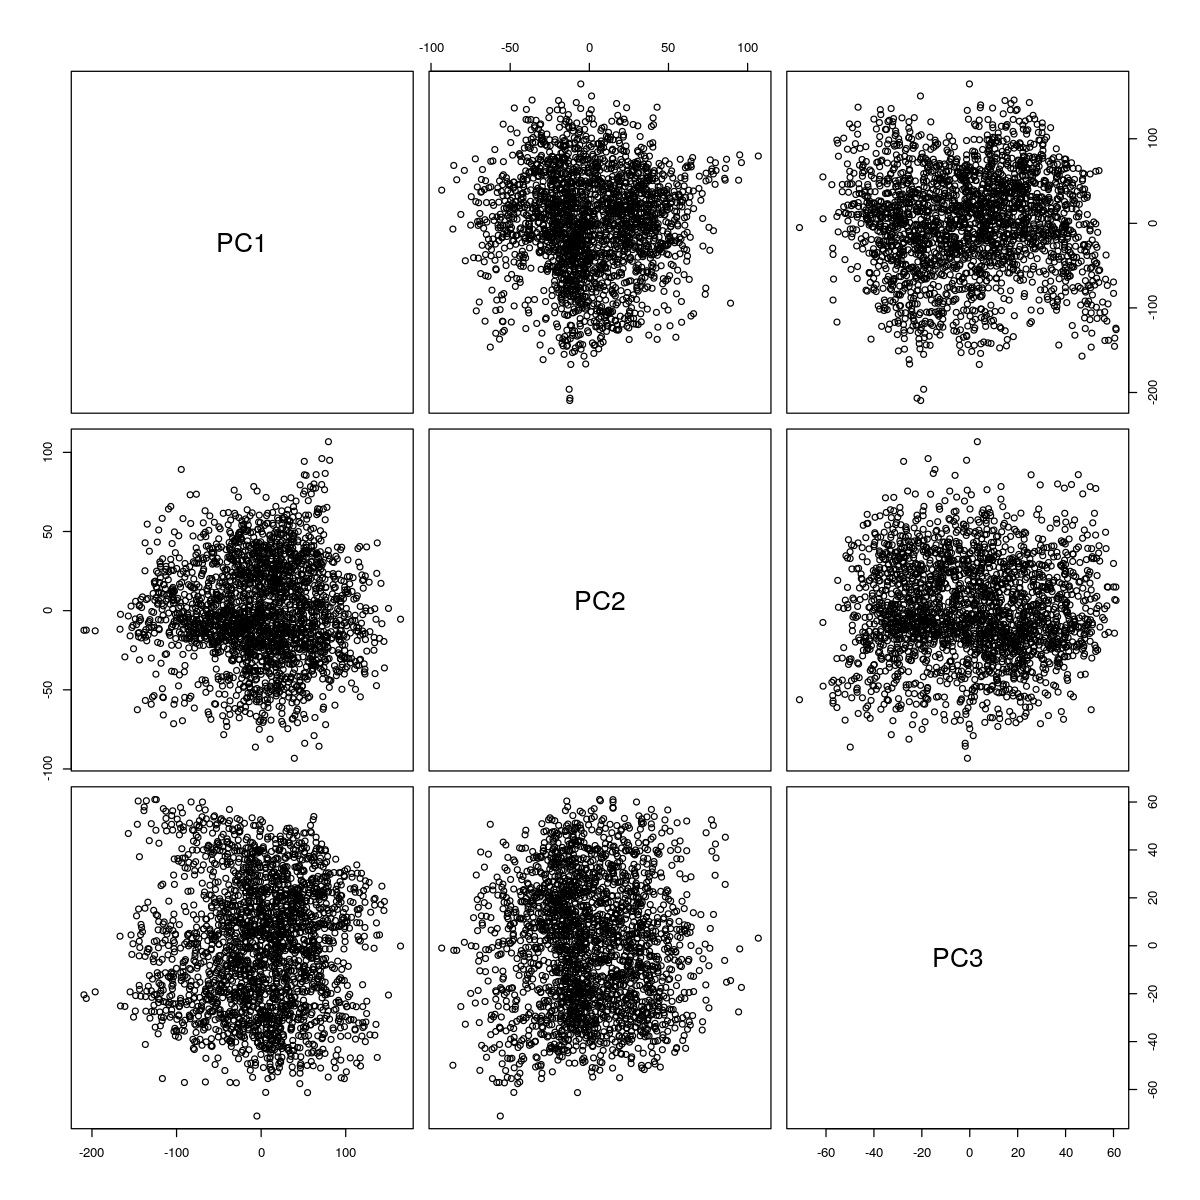

In [295]:
# Principal Components pair plots
options(repr.plot.width=10, repr.plot.height=10)
pairs(mais.pca$x[,1:3])
options(repr.plot.width=9, repr.plot.height=5)

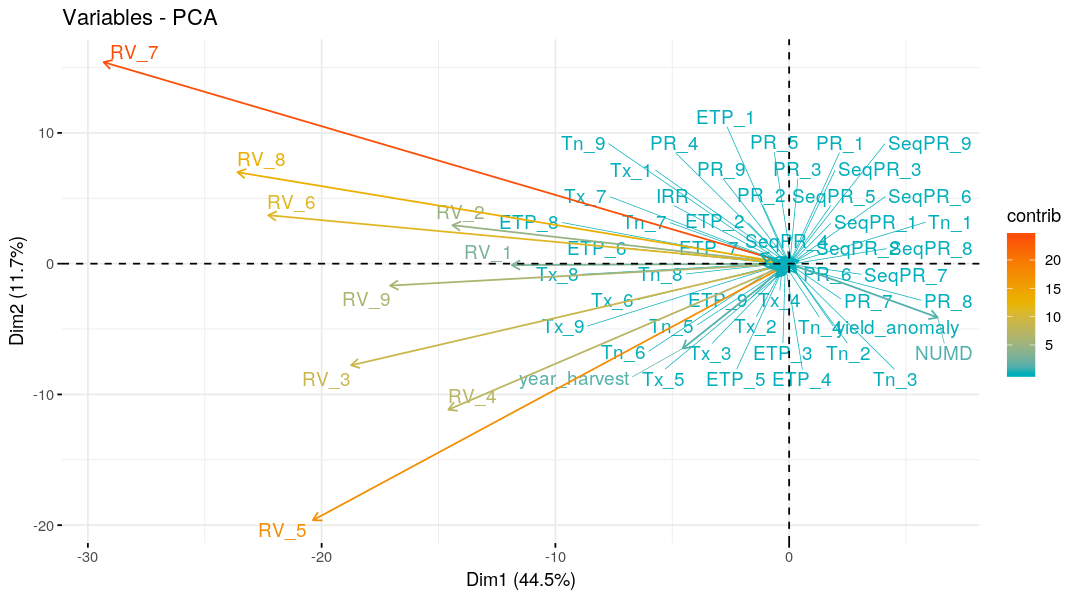

In [296]:
# PCA Variance plot
if (!require('factoextra'))
    stop("Cannot import 'factoextra'")

fviz_pca_var(mais.pca,
             col.var = "contrib",
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE)

### Variabilité des variables

In [12]:
varvar = sort(apply(mais.pre, MARGIN = 2, function(col) sd(col)), decreasing = TRUE)
low_var = varvar < 0.5
cat("Variabilité basse:\n-", paste(names(varvar)[low_var], round(varvar[low_var], digits=3), sep=':\t', collapse='\n- '))

# plot(varvar, log='y')
# axis(1, at=1:length(varvar), labels=names(varvar))

Variabilité basse:
- ETP_4:	0.464
- ETP_9:	0.44
- ETP_3:	0.361
- ETP_2:	0.234
- SeqPR_2:	0.189
- SeqPR_4:	0.185
- SeqPR_1:	0.18
- ETP_1:	0.175
- SeqPR_3:	0.168
- SeqPR_9:	0.161
- SeqPR_8:	0.16
- SeqPR_6:	0.158
- SeqPR_7:	0.157
- SeqPR_5:	0.156

In [13]:
nzv = nearZeroVar(mais.pre, saveMetrics=TRUE)
nzv

,freqRatio,percentUnique,zeroVar,nzv
year_harvest,1.000000,1.6521739,FALSE,FALSE
yield_anomaly,2.000000,99.9565217,FALSE,FALSE
NUMD,1.032258,4.0869565,FALSE,FALSE
IRR,1.026359,0.2173913,FALSE,FALSE
ETP_1,1.000000,99.8260870,FALSE,FALSE
ETP_2,1.000000,99.7826087,FALSE,FALSE
ETP_3,1.000000,99.3043478,FALSE,FALSE
ETP_4,1.000000,99.3478261,FALSE,FALSE
ETP_5,1.000000,99.4347826,FALSE,FALSE
ETP_6,1.000000,99.5217391,FALSE,FALSE


On s'aperçoit qu'il n'y a pas de variables ayant une variance quasi nulle.

### Corrélation entre les variables

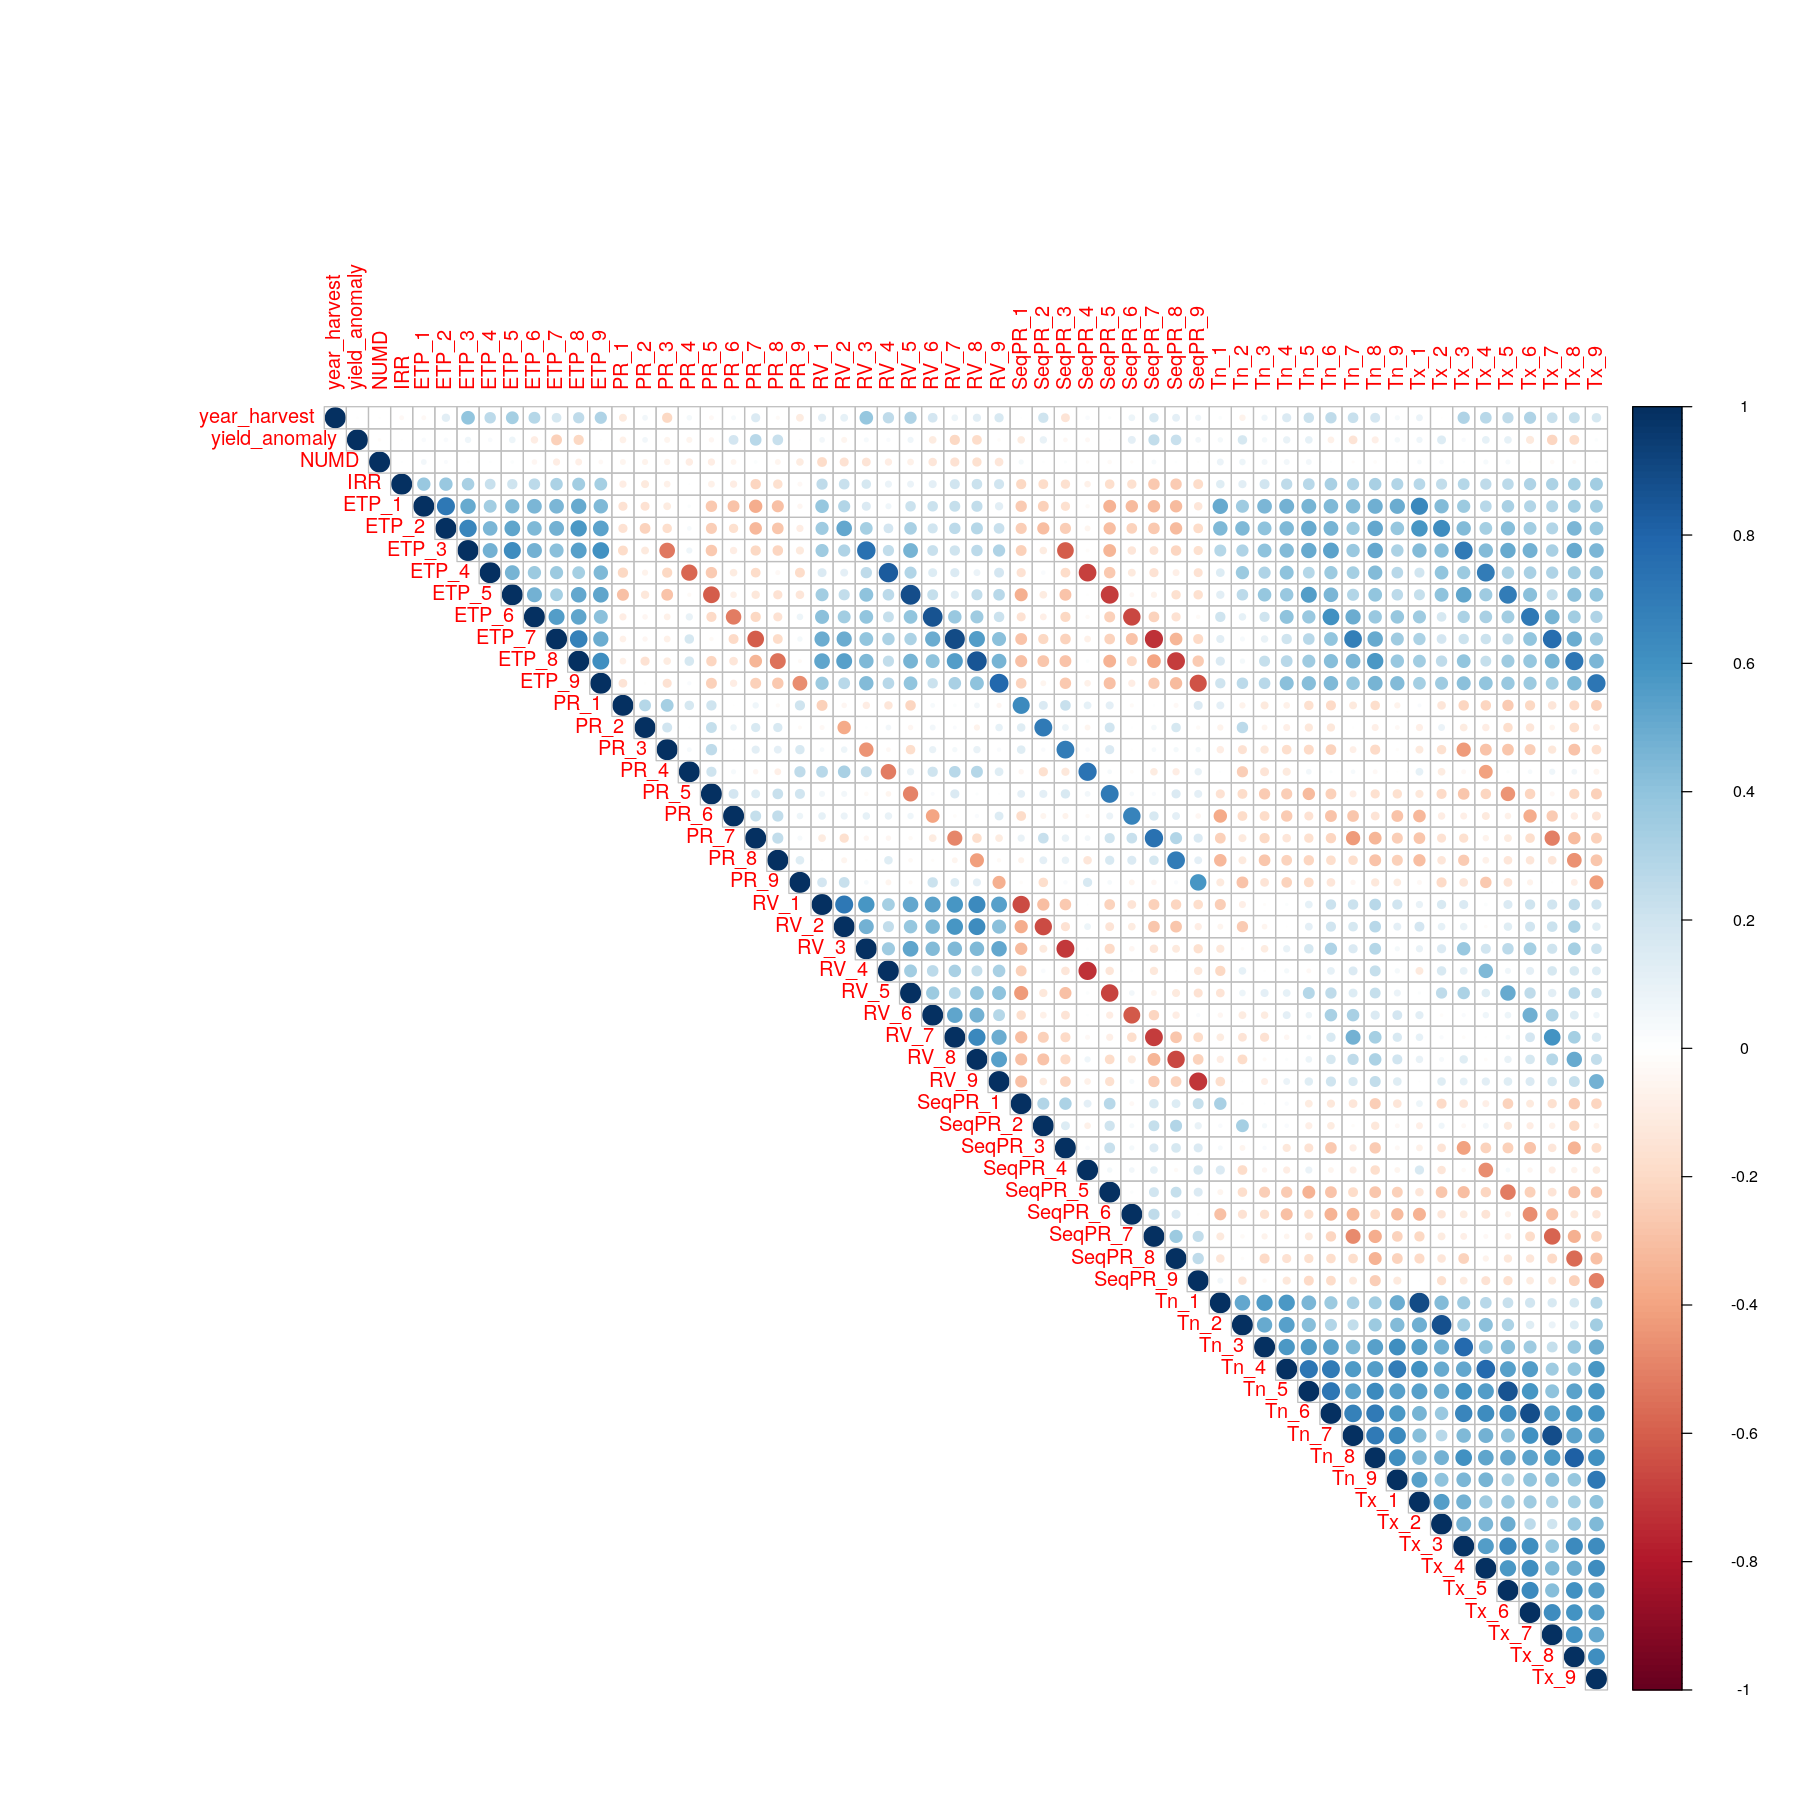

In [291]:
# Correlation
mais.corr = cor(mais.raw)

if (!require('corrplot'))
    stop("Cannot import 'corrplot'")

options(repr.plot.width=15, repr.plot.height=15)
corrplot(mais.corr, type="upper")
options(repr.plot.width=9, repr.plot.height=5)

In [9]:
# Take variables 2 by 2 and if correlation is high, only keep one
# Hypothèse !!
corr_cols = findCorrelation(mais.corr, cutoff = 0.75)
print(colnames(mais.pre)[corr_cols])

 [1] "ETP_8" "Tn_8"  "Tn_6"  "ETP_9" "ETP_7" "Tn_5"  "Tn_7"  "ETP_5" "Tx_3" 
[10] "ETP_6" "Tn_4"  "ETP_4" "Tx_1"  "Tx_2" 


On observe:
- pas de corrélation suffisante entre la variable à prédire `yield_anomaly` et les variables explicatives.
- une corrélation relativement basse ( en valeur absolue en moyenne) entre `yield_anomaly` et `ETP_i`, `PR_i`, `RV_i` et `SeqPR_i`; et une corrélation faible pour `Tn_i` et `Tx_i` avec `i`$\in [[6,8]]$
- une corrélation forte dans les groupes de variables `ETP`, `RV`, `Tn` et `TX`.

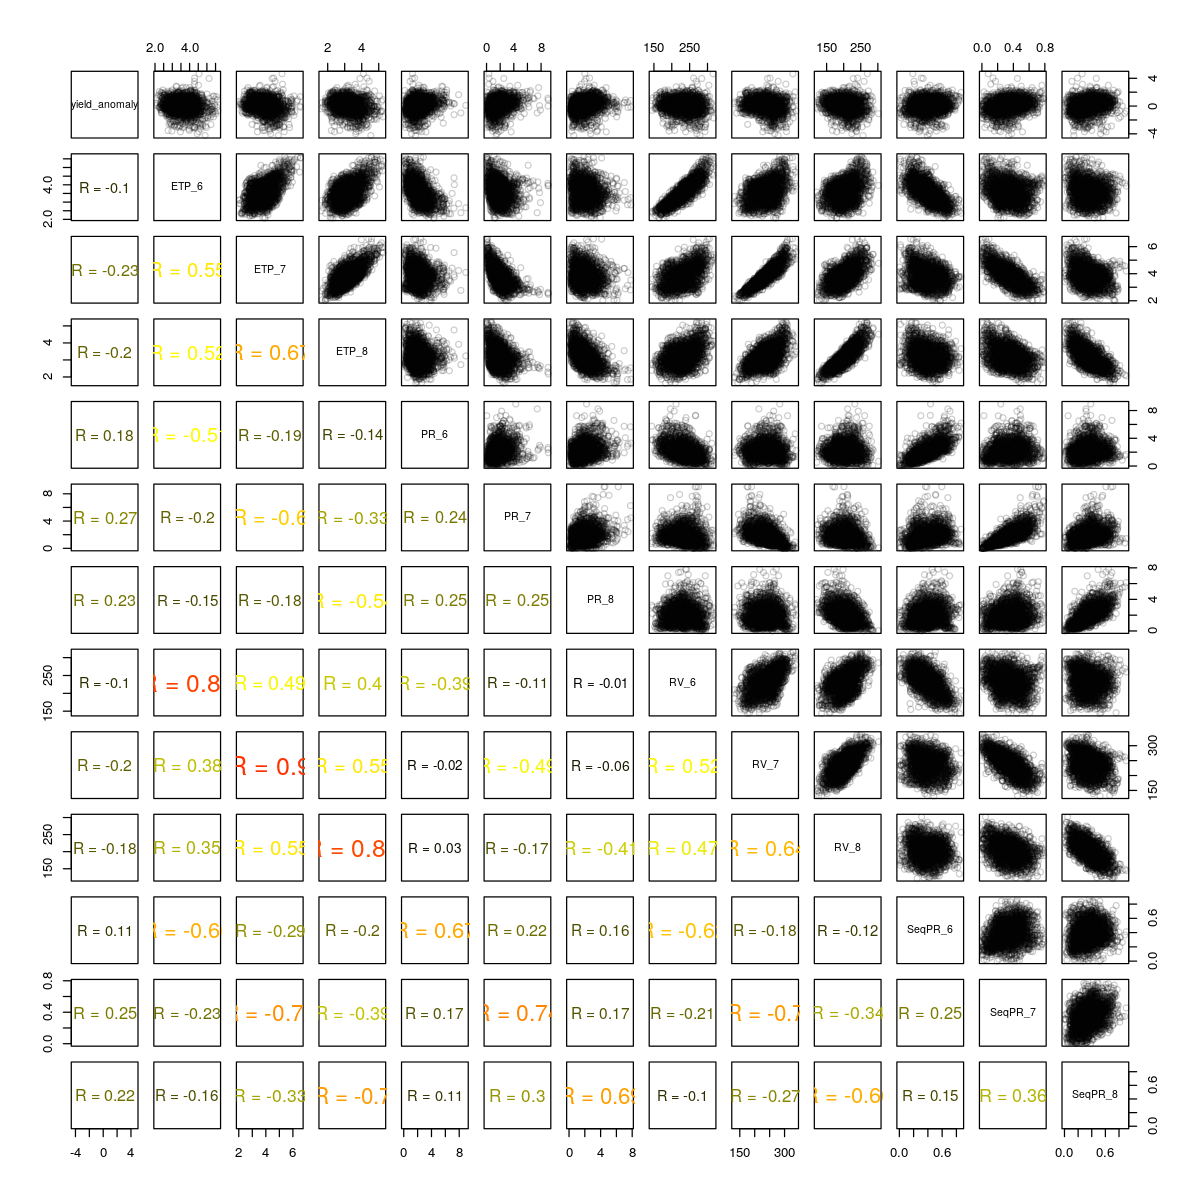

In [25]:
# TODO utile ?
cols = c('yield_anomaly', range_cols(c('ETP', 'PR', 'RV', 'SeqPR'), 6:8))

options(repr.plot.width=10, repr.plot.height=10)
pairs(mais.pre[, cols],
      lower.panel=pairs.corr,
      upper.panel=pairs.scatter)
options(repr.plot.width=9, repr.plot.height=5)

### Combinaisons linéaires

In [15]:
lin_combos = findLinearCombos(mais.pre)
lin_combos

$linearCombos
list()

$remove
NULL

Il n'y a pas de combinaisons linéaires.

### Prétraitement

In [44]:
# Test du seuil de corrélation
corr_test = list()
for (cutat in c(0.6, 0.7, 0.75, 0.8, 0.85)) {
    # Remove correlated columns
    corr_cols = findCorrelation(cor(mais.raw), cutoff = cutat)
    mais = mais.pre[, -corr_cols]
    print(paste(cutat, ncol(mais)))

    corr_test[[paste(cutat)]] = train_model('knn')
}

corr_res = resamples(corr_test)
summary(corr_res)
bwplot(corr_res)

In [5]:
# Remove correlated columns
corr_cols = findCorrelation(cor(mais.raw), cutoff = 0.75)

In [371]:
# All data transformations possible
mais.no_corr = mais.pre[, -corr_cols]
mais.no_corr.raw = mais.raw[, -corr_cols]
mais.no_corr.pca = prcomp(extract_x(mais.no_corr.raw))

#### Essai des prétraitements

In [482]:
# All preprocessings available
preprocess.data = list(
    'Classique' = mais.pre,
    'ACP' = pca_to_data(mais.pca)
)

MIX_PCA_CORR = FALSE

# PCA and Corr double loop
for (pca_coeff in c(0.85, 0.9, 0.95)) {
    # Simple PCA
    pca_key = paste('ACP à ', pca_coeff*100, '%', sep='')
    preprocess.data[[pca_key]] = pca_to_data(mais.pca, coeff = pca_coeff)
    
    # Correlation removal
    for (corr_coeff in c(0.65, 0.75, 0.85)) {
        corr_key = paste('Corrélation coupée à', corr_coeff)        
        if (!(corr_key %in% preprocess.data))
          preprocess.data[[corr_key]] = mais.raw[, -findCorrelation(mais.raw.corr, cutoff = corr_coeff)]
        
        if (!MIX_PCA_CORR)
            break
        
        # Corr and PCA
        full_key = paste(corr_key, pca_key, sep=', ')
        no_corr_pca = prcomp(extract_x(preprocess.data[[corr_key]]))
        preprocess.data[[full_key]] = pca_to_data(no_corr_pca, coeff = pca_coeff)
    }   
}

# Split datasets
for (key in names(preprocess.data))
    preprocess.data[[key]] = split(preprocess.data[[key]], p=0.2)

In [486]:
# Preprocess training
seed = NULL
preprocess.models = c('lm', 'svmRadial')
preprocess.store = list()
for (model in preprocess.models) {
    for (data_key in names(preprocess.data)) {
        full_key = paste(model, data_key, sep=' - ')
        preprocess.store[[full_key]] = train_model(model, seed=seed, data=preprocess.data[[data_key]]$train)
    }
}
preprocess.store.full = preprocess.store

INFO Training model lm took 1.26s
INFO Training model lm took 1.12s
INFO Training model lm took 1.09s
INFO Training model lm took 1.08s
INFO Training model lm took 1.28s
INFO Training model lm took 1.13s
INFO Training model lm took 1.23s
INFO Training model lm took 1.29s
INFO Training model lm took 1.26s
INFO Training model lm took 1.24s
INFO Training model lm took 1.25s
INFO Training model lm took 1.2s
INFO Training model lm took 1.15s
INFO Training model lm took 1.12s
INFO Training model lm took 1.21s
INFO Training model lm took 1.19s
INFO Training model lm took 1.11s
INFO Training model svmRadial took 17.06s
INFO Training model svmRadial took 17.96s
INFO Training model svmRadial took 19.68s
INFO Training model svmRadial took 17.69s
INFO Training model svmRadial took 17.42s
INFO Training model svmRadial took 16.77s
INFO Training model svmRadial took 16.06s
INFO Training model svmRadial took 16.71s
INFO Training model svmRadial took 16.19s
INFO Training model svmRadial took 16.44s
INF

In [518]:
preprocess.store = list()
for (key in names(preprocess.store.full))
    if (!grepl(',', key))
        preprocess.store[[key]] = preprocess.store.full[[key]]

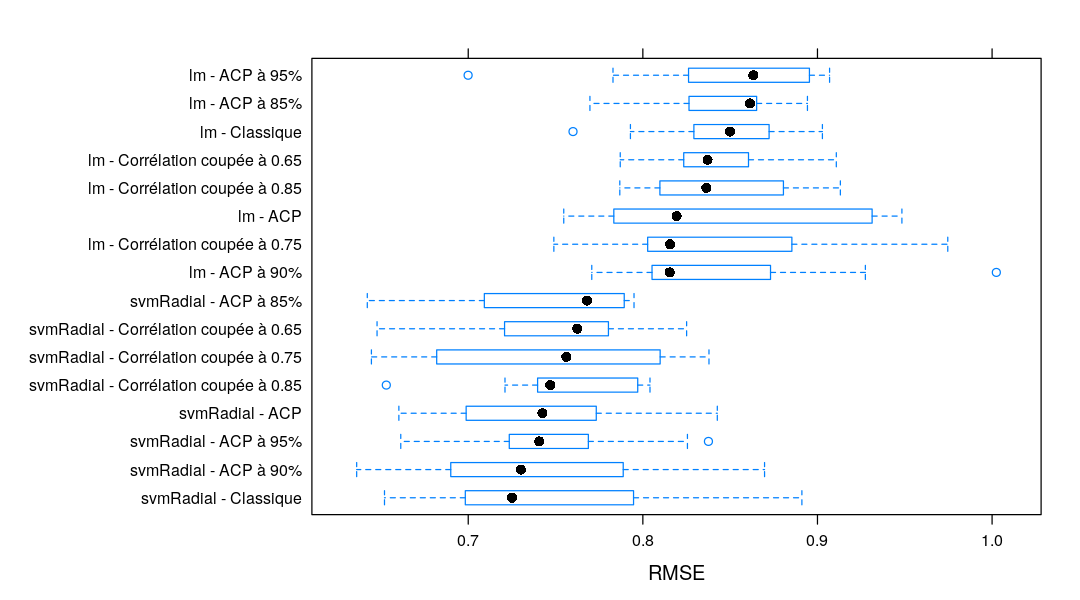

In [524]:
# Training results
preprocess.results.train = resamples(preprocess.store)
# summary(preprocess.results.train, metric='RMSE')
bwplot(preprocess.results.train, metric='RMSE')

In [529]:
# Test results
preprocess.results.test = list()
for (model in preprocess.models) {
    for (data_key in names(preprocess.data)) {
        full_key = paste(model, data_key, sep=' - ')
        if (full_key %in% names(preprocess.store)) {
            pred = predict(preprocess.store[[full_key]], newdata=preprocess.data[[data_key]]$test)
            preprocess.results.test[[full_key]] = postResample(pred, preprocess.data[[data_key]]$test$yield_anomaly)
        }
    }
}

# Store results as a dataframe and sort it by RMSE
preprocess.results.test = as.data.frame(t(data.frame(preprocess.results.test)))
rownames(preprocess.results.test) = names(preprocess.store)
preprocess.results.test[order(preprocess.results.test$RMSE),]

,RMSE,Rsquared,MAE
svmRadial - ACP,0.7551138,0.4573560,0.5581950
svmRadial - ACP à 95%,0.7553843,0.4570019,0.5583599
svmRadial - Corrélation coupée à 0.75,0.7554508,0.4569137,0.5583899
svmRadial - Corrélation coupée à 0.65,0.7555160,0.4568269,0.5584369
svmRadial - ACP à 85%,0.7559233,0.4562949,0.5586737
svmRadial - ACP à 90%,0.7560489,0.4561311,0.5587450
svmRadial - Corrélation coupée à 0.85,0.7561517,0.4559943,0.5587997
svmRadial - Classique,0.7562799,0.4558403,0.5588804
lm - Classique,0.8697048,0.2731012,0.6499535
lm - ACP,0.8697048,0.2731012,0.6499535


In [547]:
# Train - Test mix
preprocess.results = data.frame(
    Training = as.data.frame(summary(preprocess.results.train, metric='RMSE')$statistics$RMSE)$Mean,
    Test = preprocess.results.test$RMSE
)
rownames(preprocess.results) = rownames(preprocess.results.test)
preprocess.results$Mean = apply(preprocess.results, 1, mean)
preprocess.results[order(preprocess.results$Mean),]

,Training,Test,Mean
svmRadial - ACP à 90%,0.7440794,0.7560489,0.7500641
svmRadial - ACP,0.7472021,0.7551138,0.7511579
svmRadial - ACP à 85%,0.7471876,0.7559233,0.7515555
svmRadial - Corrélation coupée à 0.75,0.7483526,0.7554508,0.7519017
svmRadial - Corrélation coupée à 0.65,0.7486529,0.7555160,0.7520845
svmRadial - Classique,0.7479744,0.7562799,0.7521272
svmRadial - Corrélation coupée à 0.85,0.7504294,0.7561517,0.7532906
svmRadial - ACP à 95%,0.7513079,0.7553843,0.7533461
lm - Corrélation coupée à 0.75,0.8408552,0.8697048,0.8552800
lm - ACP à 85%,0.8435839,0.8697048,0.8566444


## Exploration des modèles

### Méthode d'apprentissage

Avant tout nous séparons notre ensemble de données en:
- _train_ (80%): utilisé pour l'apprentissage des modèles
- _test_ (20%): utilisé pour évaluer les modèles


La méthode `train` du package `caret` permet d'évaluer les performances d'un modèle rapidement et simplement.
Elle fonctionne de la façon suivante:
- pour un modèle donné (par exemple `lm`)
- pour une grille de valeurs de paramètres à tester
    - pour chaque set de paramètres:
        - pour chaque échantillon _train_-_test_ de la validation croisée:
            - entrainer le modèle avec les paramètres sur _train_
            - évaluer ses performances avec diverses métriques sur _test_
    - calcul des performances moyennes du set de paramètres sur la validation croisée
- garder le meilleur set de paramètres (pour la régression, meilleur RMSE)
- rentrainer un modèle avec ce set sur toutes les données

Pour cette méthode `train`, nous utilisons une Validation Croisée à 10 plis des données _train_.

In [353]:
# Choose data   
mais = mais.pre[, -findCorrelation(mais.corr, cutat = 0.75)]

# Training - test split
test.index = createDataPartition(mais$yield_anomaly, p=0.2, list=FALSE)
# mais.centered = as.data.frame(scale(mais, center = TRUE, scale = TRUE))
mais.train = mais[-test.index,]
mais.test = mais[test.index,]
cat(paste(dim(mais), collapse=' x '), ' => train: ', nrow(mais.train), ', test: ', nrow(mais.test), sep='')

# Get cross test training control
trainingCV = trainControl(method="cv", number=10, allowParallel=TRUE)

2300 x 44 => train: 1840, test: 460

In [437]:
# Standard way to create train_model option
make_options = function(params, ...) c(list(params=params), list(...))

# Train one model with specified params
train_model = function(method, params = NULL, CV = TRUE, seed = NULL, ...) {
    options = list(...)

    # First, add params to options
    if (is.list(params))
        options$tuneGrid = expand.grid(params)
    else if (is.numeric(params))
        options$tuneLength = params
    else if (!is.null(params))
        warning(paste("Unrecognized parameter type :", params))

    # Then, add constant options
    options = c(list(
        yield_anomaly ~ .,
        trControl = if (CV) trainingCV else trainControl(number=1),
        method = method
    ), options)
    
    # Add classic data if not provided
    if (is.null(options$data))
        options$data = mais.train
    
    if (!is.null(seed))
        set.seed(seed)
    
    # Then, train and return model
    t_start = Sys.time()
    model = (do.call(train, options))
    t_end = Sys.time()
    t_diff = round(as.numeric(t_end - t_start, units="secs"), digits=2)
    cat("INFO Training model ", method, " took ", t_diff, "s\n", sep = "")
    return(model)
}

### Modèles à tester
Regression avec variables qualitatives
- Tree based model
- Random Forest
- Bagging
- Regression Mixture (em)
- Regression Qualitative (regression avec R)
- Regression Mixte
- SVM ??
- Stepwise regression
- Gaussian process ??

#### Essai d'un modèle

In [580]:
modelLookup('rpart')

model,parameter,label,forReg,forClass,probModel
rpart,cp,Complexity Parameter,TRUE,TRUE,TRUE


In [601]:
params_rf = models.store$rf$bestTune
params_rf

,mtry
4,16


In [604]:
# Try one model
params = list(
    df=seq(1,4, length.out = 6)
)

model = train_model('rf', tuneGrid=params_rf, ntree=200)
model

INFO Training model rf took 68.89s


Random Forest 

1840 samples
  43 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1656, 1656, 1656, 1656, 1656, 1656, ... 
Resampling results:

  RMSE       Rsquared   MAE      
  0.7616328  0.4298477  0.5567888

Tuning parameter 'mtry' was held constant at a value of 16

In [605]:
x = resamples(list(
    new=model,
    old=models.store$rf
))
summary(x)


Call:
summary.resamples(object = x)

Models: new, old 
Number of resamples: 10 

MAE 
         Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
new 0.4962399 0.5208324 0.5427546 0.5567888 0.5993481 0.6401615    0
old 0.5208432 0.5296629 0.5514109 0.5540984 0.5648240 0.6030772    0

RMSE 
         Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
new 0.6553760 0.7141963 0.7286449 0.7616328 0.8458576 0.8857002    0
old 0.6693754 0.6955726 0.7486635 0.7507389 0.8034935 0.8284128    0

Rsquared 
         Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
new 0.2642068 0.4061146 0.4520734 0.4298477 0.4685648 0.5240729    0
old 0.3433463 0.4115690 0.4387788 0.4448806 0.4680240 0.5753212    0


INFO Training model rf took 69.71s
INFO Training model rf took 118.14s
INFO Training model rf took 175.18s


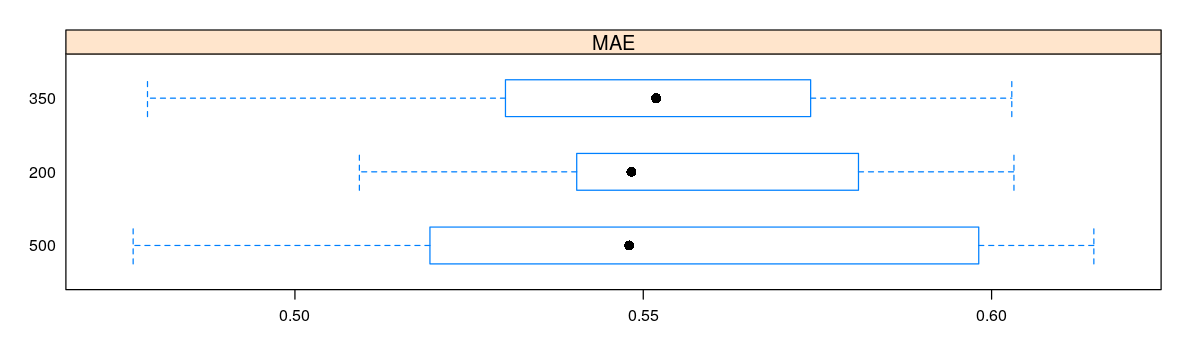

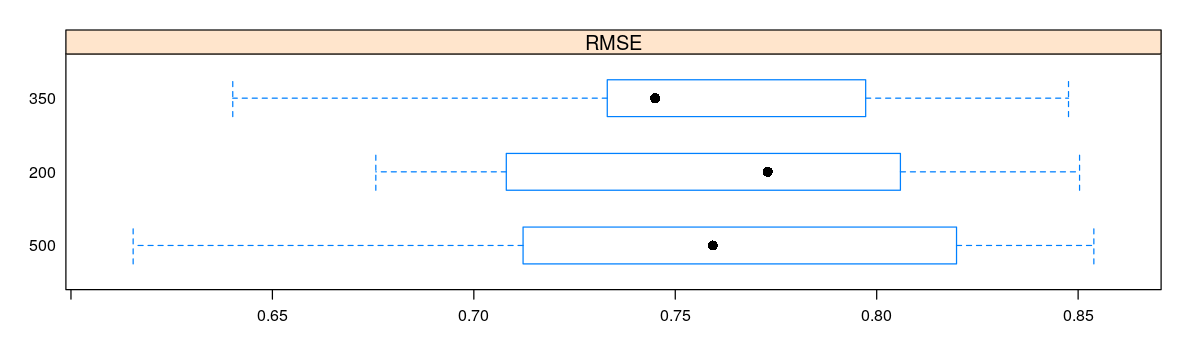

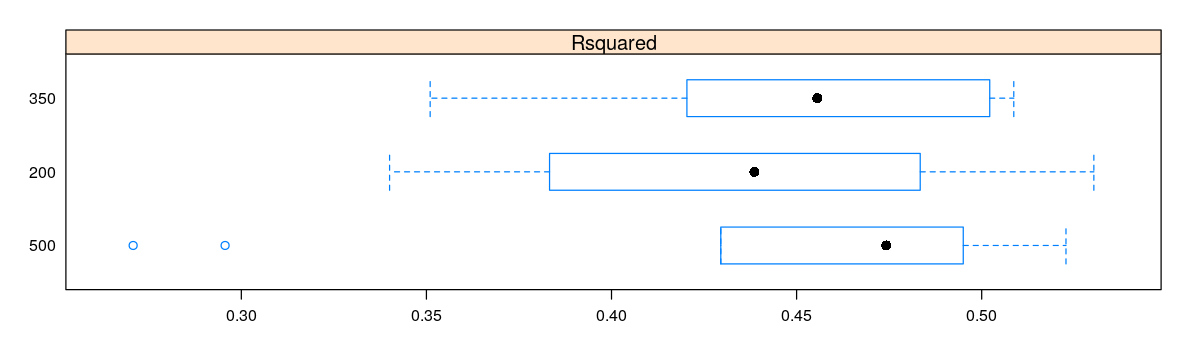

In [606]:
# Try multiple models
method = 'svmRadial'
params = 3
seed = 1234

options(repr.plot.width=10, repr.plot.height=3)
bwplot(resamples(list(
    '200' = train_model('rf', tuneGrid=params_rf, ntree=200),
    '350' = train_model('rf', tuneGrid=params_rf, ntree=350),
    '500' = train_model('rf', tuneGrid=params_rf, ntree=500)

#             norm = train_model(method, params, preProcess=c("center", "scale", "YeoJohnson")),
#             scaled = train_model(method, params, preProcess=c("center", "scale")),
#             non_scaled = train_model(method, params)
       )),
       scales=list(x=list(relation="free")),
       layout = c(length(models.compare$metrics), 1))
options(repr.plot.width=9, repr.plot.height=5)

#### Paramètres des différents modèles

In [10]:
# Models params stores
models.params = list(

    # ---------- Regressions ----------

    # Linear Regression
    lm = make_options(list(
        intercept=c(FALSE, TRUE)
    )),
    # Linear Regression with Stepwise Selection
    lmStepAIC = make_options(
        NULL,
        direction = 'forward',
        trace = FALSE
    ),
    
    # Partial Least Squares Regression
    pls = make_options(ncol(mais) - 1),
    # Principal Component Regression
    pcr = make_options(ncol(mais) - 1),

    # Ridge Regression
    ridge = make_options(6),
    # Lasso Regression
    lasso = make_options(11),
    # Elasticnet
    enet = make_options(5),

    
    # Generalized Linear Model
#     glm = make_options(list(
#         parameter = parameter
#     )),

    # Lasso and Elastic-Net Regularized Generalized Linear Models
#     glmnet = make_options(list(
#         alpha = Mixing Percentage,
#         lambda = Regularization Parameter
#     )),

#     # Generalized Linear Model with Stepwise Feature Selection
#     glmStepAIC = make_options(list(
#         parameter = parameter
#     )),


    # ---------- Tree based ----------

    # CART
    rpart = make_options(10),

    # Random Forest
    rf = make_options(10),

    # ---------- GLM ----------

    # Generalized Additive Model using Splines
    gamSpline = make_options(list(
        df=seq(1,4, length.out = 7)
    )),

    # ---------- SVM ----

    # Support Vector Machines with Linear Kernel
    svmLinear = make_options(NULL),

    # Support Vector Machines with Polynomial Kernel
    svmPoly = make_options(list(
        C = c(1, 10, 50, 100, 150),
        degree = 1:5,
        scale = 0.001
    )),

    # Support Vector Machines with Radial Basis Function Kernel
    svmRadial = make_options(6),

    # ---------- Other ----------

    # k-Nearest Neighbors
    knn = make_options(10)
)

#### Apprentissage

In [11]:
# Training loop
models.store = list()

t_start = Sys.time()
n_models = length(models.params)
pb = txtProgressBar(min=0, max=n_models, initial=0, style=3)
i = 0

set.seed(123)
for (model in names(models.params)) {
    params = models.params[[model]]
    print(paste("Training ", model, " (", i, "/", n_models, ")", sep=""))
    tryCatch({
        params$method = model
        models.store[[model]] = do.call(train_model, params)
    }, error=function(error) {
        cat("\nERROR with model", model, ": \n", error, "\n")
        models.store[[model]] = error
    })
    i = i + 1
    setTxtProgressBar(pb, i)
}

t_end = Sys.time()
close(pb)
t_diff = round(as.numeric(t_end - t_start, units="mins"), digits=2)
cat("\nDone !!\nFull training took ", t_diff, "min\n", sep = "")

  |                                                                      |   0%[1] "Training lm (0/14)"
INFO Training model lm took 1.63s
  |=====                                                                 |   7%[1] "Training lmStepAIC (1/14)"
INFO Training model lmStepAIC took 1.22s
  |==========                                                            |  14%[1] "Training pls (2/14)"
INFO Training model pls took 2.44s
  |===============                                                       |  21%[1] "Training pcr (3/14)"
INFO Training model pcr took 1.75s
  |====================                                                  |  29%[1] "Training ridge (4/14)"
INFO Training model ridge took 6.7s
  |=========================                                             |  36%[1] "Training lasso (5/14)"
INFO Training model lasso took 1.97s
  |==============================                                        |  43%[1] "Training enet (6/14)"
INFO Training model enet took 5.97s
 

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

INFO Training model rpart took 2.27s
  |========================================                              |  57%[1] "Training rf (8/14)"
INFO Training model rf took 2130.55s
  |=============================================                         |  64%[1] "Training gamSpline (9/14)"
INFO Training model gamSpline took 123.23s
  |==================================================                    |  71%[1] "Training svmLinear (10/14)"
INFO Training model svmLinear took 17.3s
  |=======================================================               |  79%[1] "Training svmPoly (11/14)"
INFO Training model svmPoly took 226.03s
  |============================================================          |  86%[1] "Training svmRadial (12/14)"
INFO Training model svmRadial took 41.37s
  |=================================================================     |  93%[1] "Training knn (13/14)"
INFO Training model knn took 3.81s
  |==================================================================

In [17]:
# Save results
save(models.store, models.params, file='reg_results.Rdata')

## Evaluation des modèles

### Sur l'apprentissage

In [130]:
models.compare = resamples(models.store)
models.compare$metrics = c('RMSE') #c('RMSE', 'Rsquared', 'MAE')
summary(models.compare)


Call:
summary.resamples(object = models.compare)

Models: lm, lmStepAIC, pls, pcr, ridge, lasso, enet, rpart, rf, gamSpline, svmLinear, svmPoly, svmRadial, knn 
Number of resamples: 10 

RMSE 
               Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
lm        0.7729210 0.8192669 0.8528756 0.8492222 0.8826984 0.8975826    0
lmStepAIC 0.7766213 0.8396958 0.8624805 0.8498001 0.8693544 0.8942611    0
pls       0.7356020 0.8201092 0.8298380 0.8475959 0.8593649 1.0516180    0
pcr       0.7694968 0.8225500 0.8383233 0.8473118 0.8677294 0.9404902    0
ridge     0.7512151 0.8273373 0.8542142 0.8472460 0.8789752 0.9128283    0
lasso     0.7373037 0.8198215 0.8380769 0.8431153 0.8584519 0.9273816    0
enet      0.7460197 0.7813003 0.8491395 0.8470689 0.8851975 0.9688481    0
rpart     0.8178031 0.8689890 0.9081321 0.9151079 0.9570117 1.0336902    0
rf        0.6693754 0.6955726 0.7486635 0.7507389 0.8034935 0.8284128    0
gamSpline 0.6933361 0.7730176 0.8064346 0.7978198 0.8132

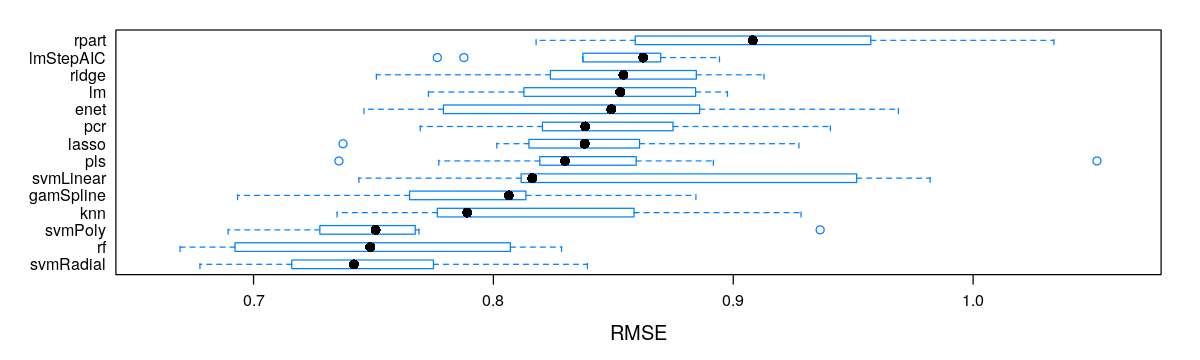

In [131]:
options(repr.plot.width=10, repr.plot.height=3)
bwplot(models.compare, scales=list(x=list(relation="free")), layout = c(length(models.compare$metrics), 1))
options(repr.plot.width=9, repr.plot.height=5)

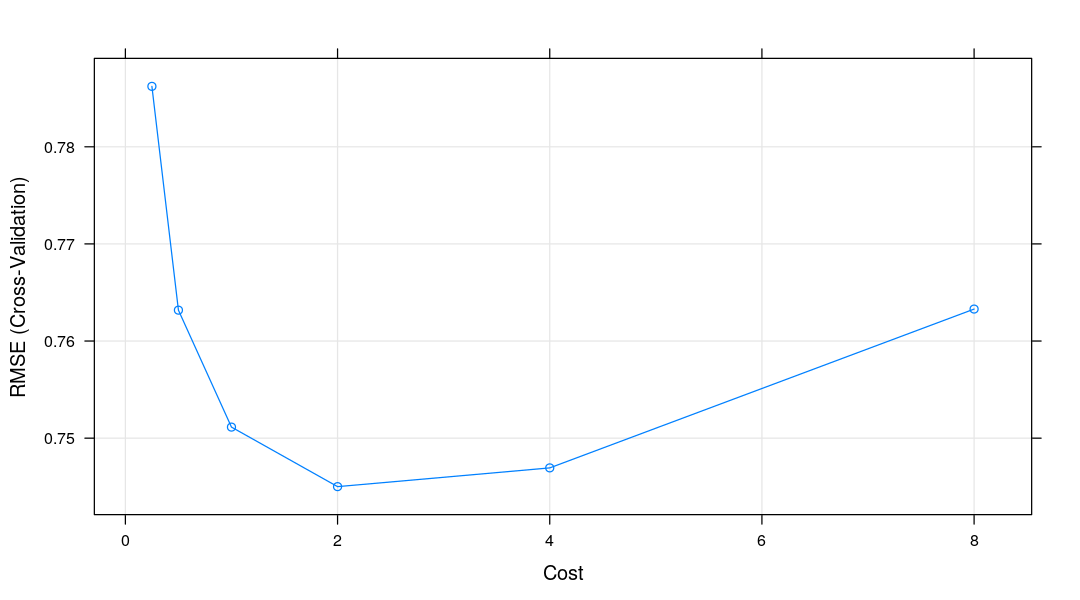

In [20]:
plot(models.store$svmRadial)

### Sur les données de test

In [104]:
# Compute results on test data by model
models.results.test = list()
obs = mais.test$yield_anomaly
for (model in names(models.store)) {
    pred = predict(models.store[[model]], newdata=mais.test)
    models.results.test[[model]] = postResample(pred, obs)
}

# Store results as a dataframe and sort it by RMSE
models.results.test = as.data.frame(t(data.frame(models.results)))
models.results.test = models.results[order(models.results$RMSE),]
models.results.test

,RMSE,Rsquared,MAE
svmRadial,0.7621118,0.4369351,0.5419620
rf,0.7694555,0.4425754,0.5529704
svmPoly,0.7929202,0.4044757,0.5686514
gamSpline,0.8189177,0.3480942,0.5992284
knn,0.8379565,0.3227341,0.5956443
lasso,0.8603314,0.2799691,0.6380255
lm,0.8605079,0.2791569,0.6392429
enet,0.8605739,0.2798556,0.6374623
ridge,0.8608076,0.2790002,0.6393296
lmStepAIC,0.8612532,0.2779326,0.6402190


### Insights

#### Régressions Linéaires

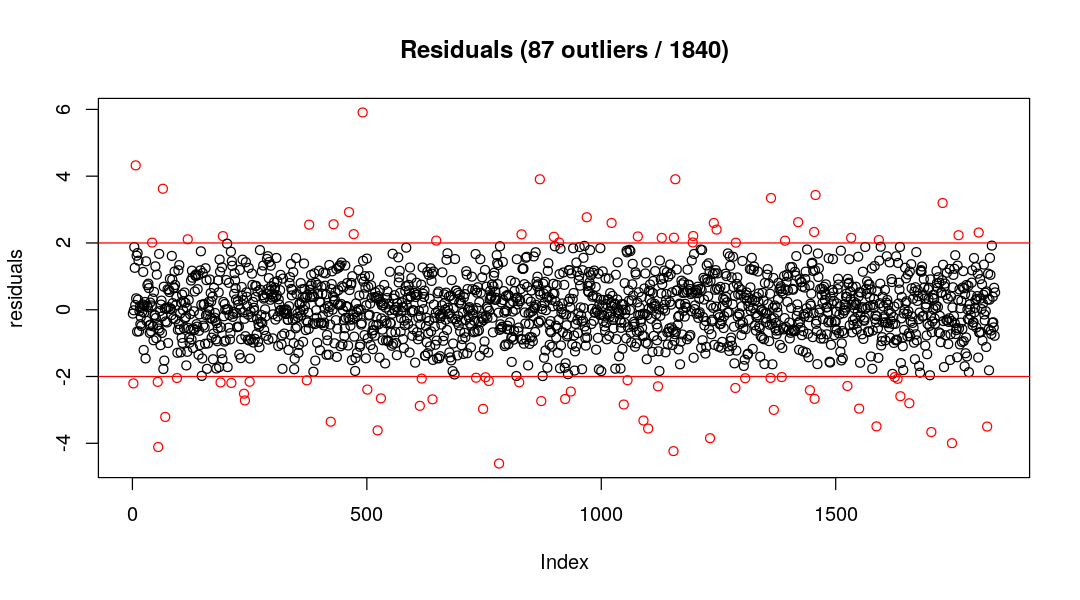

In [206]:
model = models.store$lm$finalModel

# par(mfrow=c(1,2))
# pred_true_plot(mais.train$yield_anomaly, fitted(model))
studentized_residuals_plot(rstudent(model))
# plot(0)
# mse_plot(mais.train$yield_anomaly, fitted(model))

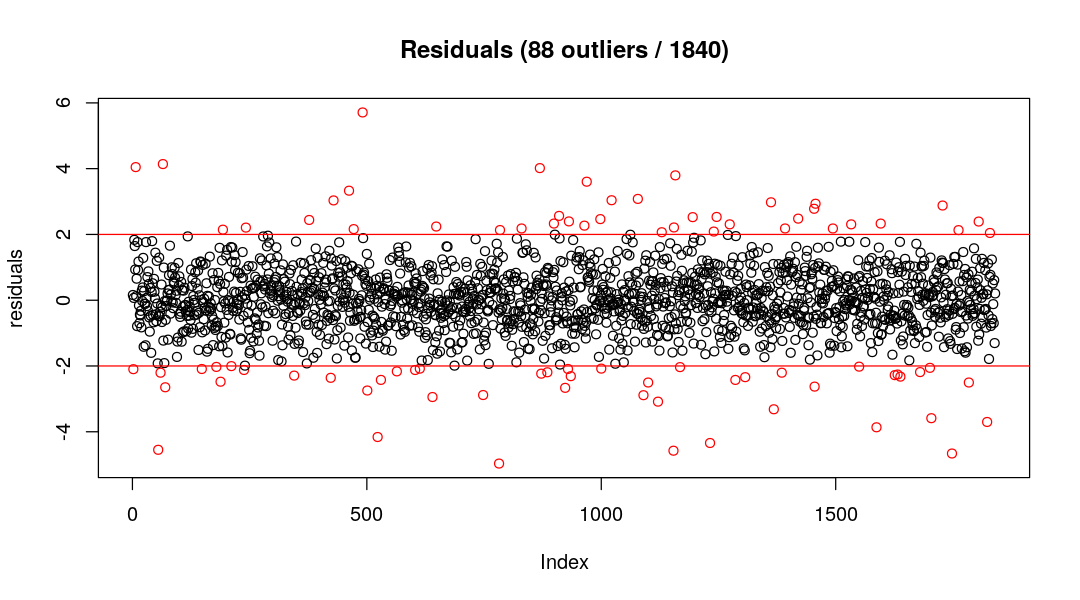

In [212]:
studentized_residuals_plot(rstudent(models.store$gamSpline$finalModel))

#### Arbres et Forêts

Warning message:
“Bad 'data' field in model 'call'.
To silence this warning:
    Call rpart.plot with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”

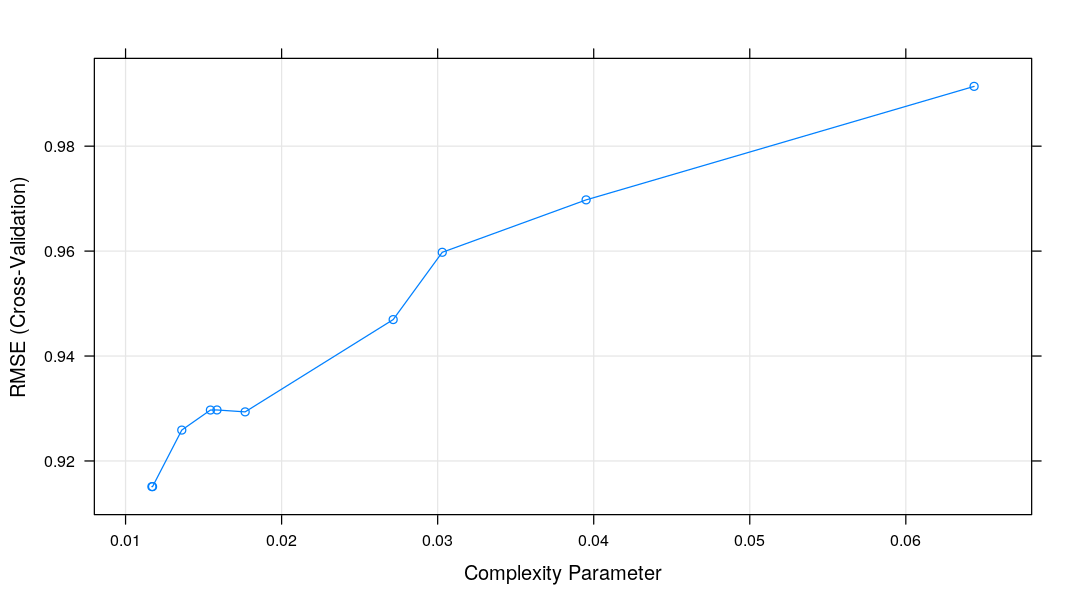

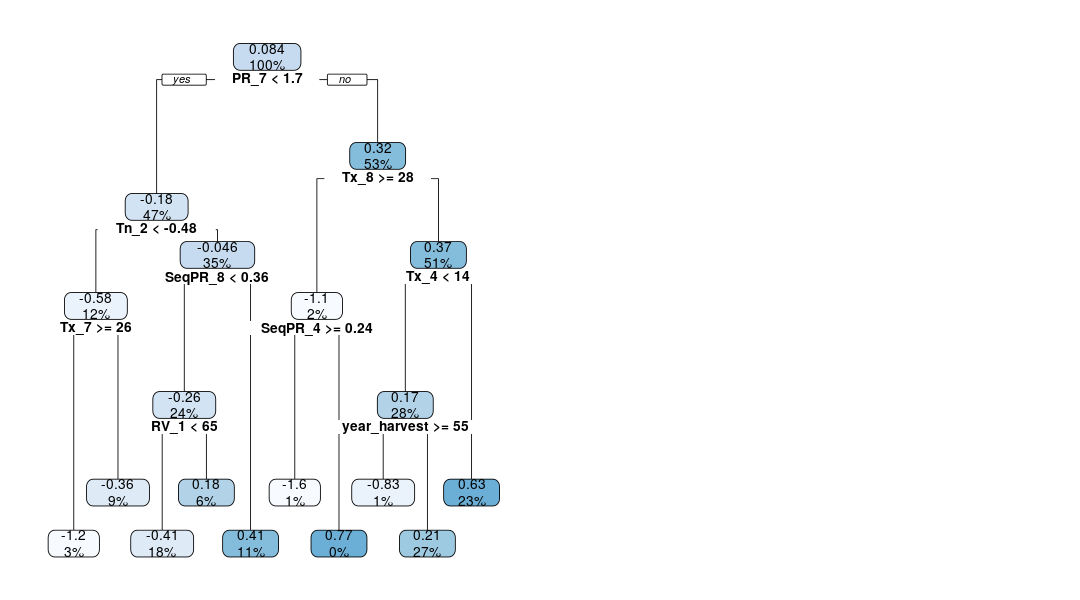

In [588]:
library(rpart.plot)
par(mfrow=c(1,2))
plot(models.store$rpart)
# rpart.plot(models.store$rpart$finalModel)
rpart.plot(models.store$rpart$finalModel)
# text(models.store$rpart$finalModel)

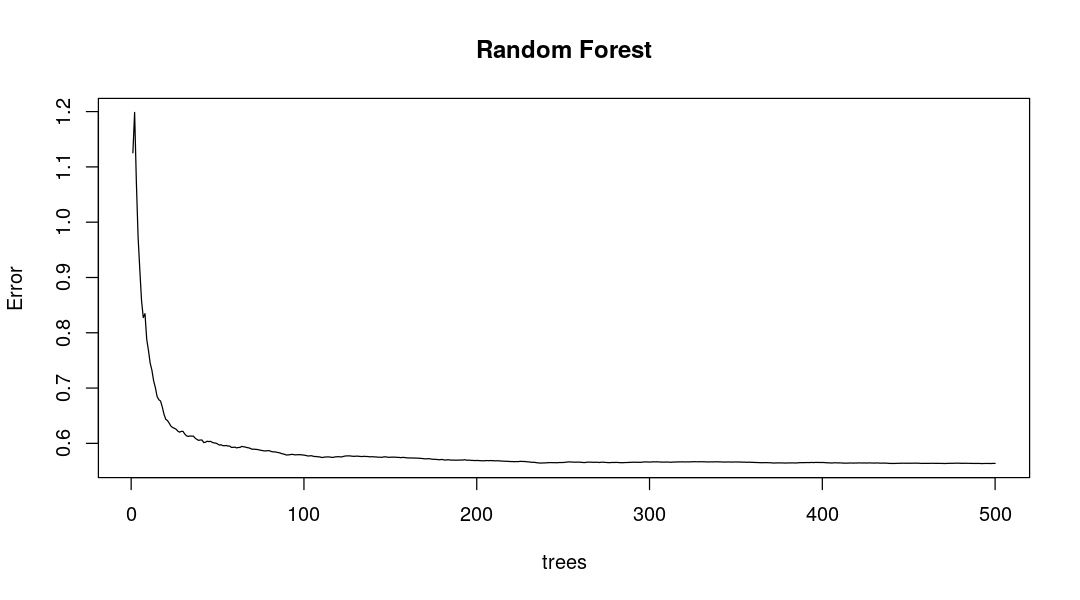

In [576]:
plot(models.store$rf$finalModel, main='Random Forest')

#### SVM

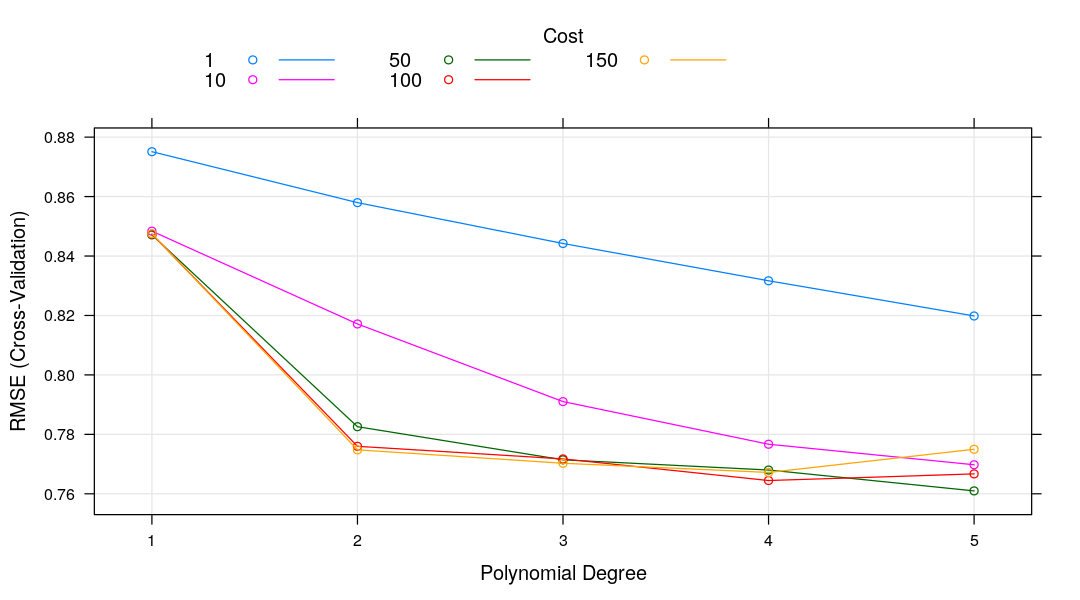

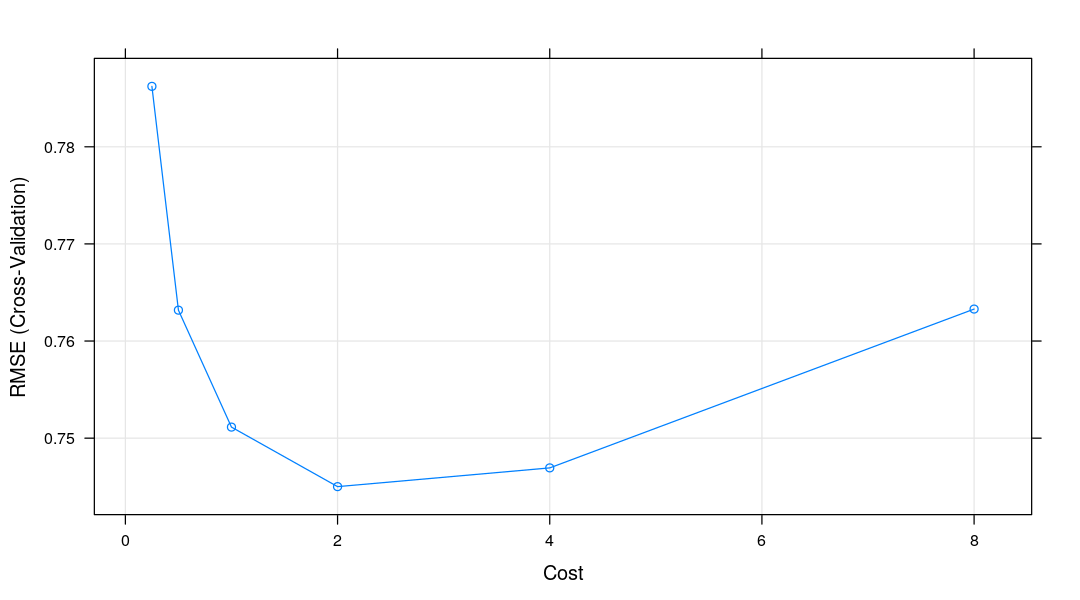

In [594]:
par(mfrow = c(2,1))
plot(models.store$svmPoly)
plot(models.store$svmRadial)

In [147]:
# Variable importance
varImp(models.store$lm)

lm variable importance

  only 20 most important variables shown (out of 46)

             Overall
Tx_6          100.00
PR_7           90.87
Tx_5           89.00
Tx_8           66.59
SeqPR_5        66.41
RV_1           64.74
Tx_4           61.29
PR_6           59.83
PR_8           56.54
Tn_1           52.37
ETP_3          50.50
PR_5           48.46
RV_3           44.62
year_harvest   43.34
RV_6           42.02
Tx_9           40.82
RV_4           38.40
SeqPR_2        36.30
SeqPR_9        36.04
SeqPR_4        33.22

### Store best model

In [613]:
# Preprocess (with factor)
reg_corr_cols = findCorrelation(mais.corr, cutoff = 0.75)
mais = mais.pre[, -reg_corr_cols]
print(dim(mais))

best_method = 'svmRadial'
best_reg_model = train(yield_anomaly ~ ., mais,
                       trControl=trainControl(method='none'),
                       method=best_method,
                       tuneGrid=models.store[[best_method]]$bestTune)
best_reg_model

[1] 2300   44


Support Vector Machines with Radial Basis Function Kernel 

2300 samples
  43 predictor

No pre-processing
Resampling: None 

In [615]:
save(reg_corr_cols, best_reg_model, file='reg_env.Rdata')